![churn](../figures/churn.png)

#  Part 1: Customer Churn Exploratory Analysis

### Goals for Part 1:
- Understand the dataset
- Test if our label (churn) is balanced or unbalanced
- User visualization to see if there are differences within certain groups relating to churn
- Encode categorical variables
- Determine which features have a strong correlation to churn

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report

In [160]:
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

In [161]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Many features appear to be categorical / strings
- ID column will not be useful for modeling
- Will drop ID column and the label ('Churn') when we create our train_test_split objects later on in the notebook

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


### Of the numerical features, 'Senior Citizen' appears to be boolean, 0 or 1

In [163]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Check for NULL values
- There are no NULL values
- If there were, we can either drop them, or try to fill in missing values
    -  median or a mean of a similar group might work well

In [164]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Check cardinality of the features in the dataset
- A high number of unique values means the feature is either numerical or a unique ID
- A low number of unique values means the featur is likely categorical

In [165]:
df.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

### Check for how balanced the label is
- This dataset is relatively balanced
- Imbalanced labels will lead to accuracy issues for machine learning predictions
- We will run ML predictions on both the original dataset and a resampled version of the dataset and compare metrics later


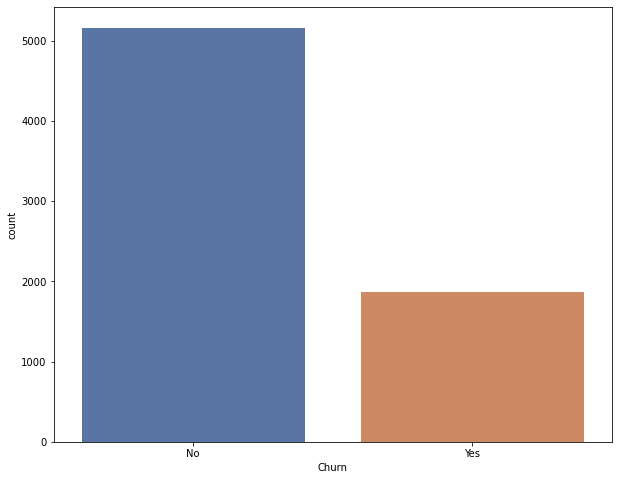

In [166]:
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(data=df, x='Churn', ax=ax);

In [167]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [168]:
df['Churn'].value_counts(normalize=True).mul(100)

No     73.421502
Yes    26.578498
Name: Churn, dtype: float64

### Churn Observations
- Customers who have left have lower total charges than customers who have stayed
- Month to month customers have the lowest total charges
    - Total charges are closer for month-to-month customers, regardless of churn status
    - This makes sense, as people who are on month-to-month plans are not committed and are probably looking for flexability
- Looking at the 1 and 2 year contracts, customers who left have higher total charges than those that stayed
    - Higher costs potentially drove away customers
    - Possible solution to keep customers would be fee rebates or cost reductions tied to contract milestones

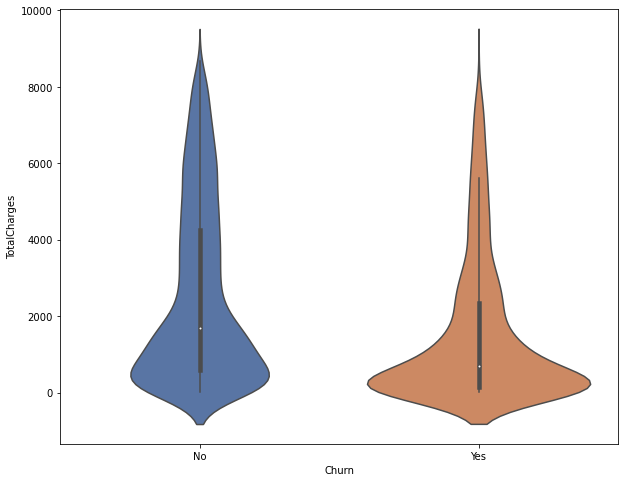

In [169]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(data=df, ax=ax, x='Churn', y='TotalCharges');

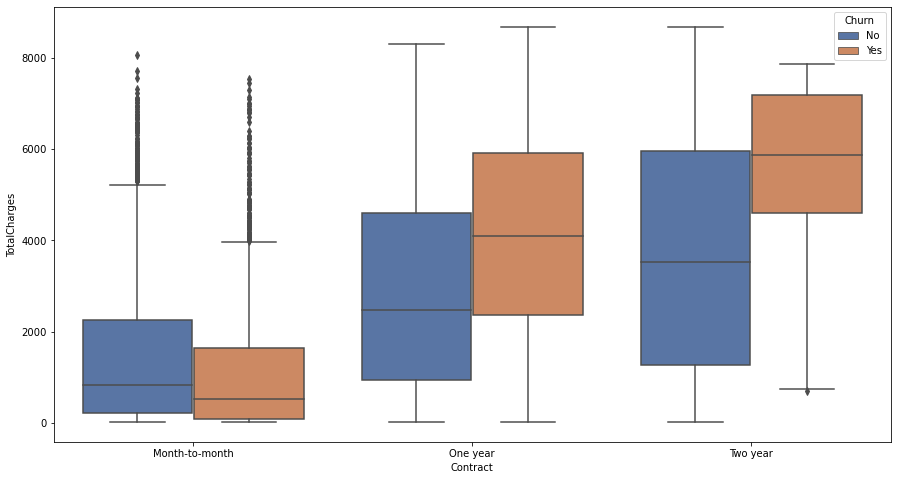

In [170]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, ax=ax, x='Contract', y='TotalCharges', hue='Churn');

### Correlation analysis
- Convert categorical features into numerical format via one-hot encoding 
- Drop columns that have high cardinality
- Calculate the correlation coefficient

In [171]:
df_subset = df.loc[:,df.nunique()<10]
corr = pd.get_dummies(df_subset).corr()
corr.head()

,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
SeniorCitizen,1.000000,0.001819,-0.001819,-0.016957,0.016957,0.210550,-0.210550,-0.008392,0.008392,-0.136377,...,-0.046491,-0.116205,-0.156258,0.156258,-0.016235,-0.024359,0.171322,-0.152987,-0.150541,0.150541
gender_Female,0.001819,1.000000,-1.000000,-0.001379,0.001379,0.010349,-0.010349,-0.007515,0.007515,-0.004335,...,-0.007755,0.003603,-0.011902,0.011902,0.015973,-0.001632,-0.000844,-0.013199,-0.008545,0.008545
gender_Male,-0.001819,-1.000000,1.000000,0.001379,-0.001379,-0.010349,0.010349,0.007515,-0.007515,0.004335,...,0.007755,-0.003603,0.011902,-0.011902,-0.015973,0.001632,0.000844,0.013199,0.008545,-0.008545
Partner_No,-0.016957,-0.001379,0.001379,1.000000,-1.000000,0.452269,-0.452269,0.018397,-0.018397,0.130028,...,-0.083067,-0.247334,-0.013957,0.013957,-0.111406,-0.082327,0.083207,0.096948,-0.149982,0.149982
Partner_Yes,0.016957,0.001379,-0.001379,-1.000000,1.000000,-0.452269,0.452269,-0.018397,0.018397,-0.130028,...,0.083067,0.247334,0.013957,-0.013957,0.111406,0.082327,-0.083207,-0.096948,0.149982,-0.149982


In [172]:
corr_sort = (corr['Churn_Yes'].sort_values()
                              .iloc[1:-1] # selects the first row through the second to last (not including Churn_No) 
            )
corr_sort

Contract_Two year                         -0.301552
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
TechSupport_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
OnlineBackup_No internet service          -0.227578
OnlineSecurity_No internet service        -0.227578
InternetService_No                        -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

### Visualize the correlation coeeficients
- Ordered barplot
- Heatmap

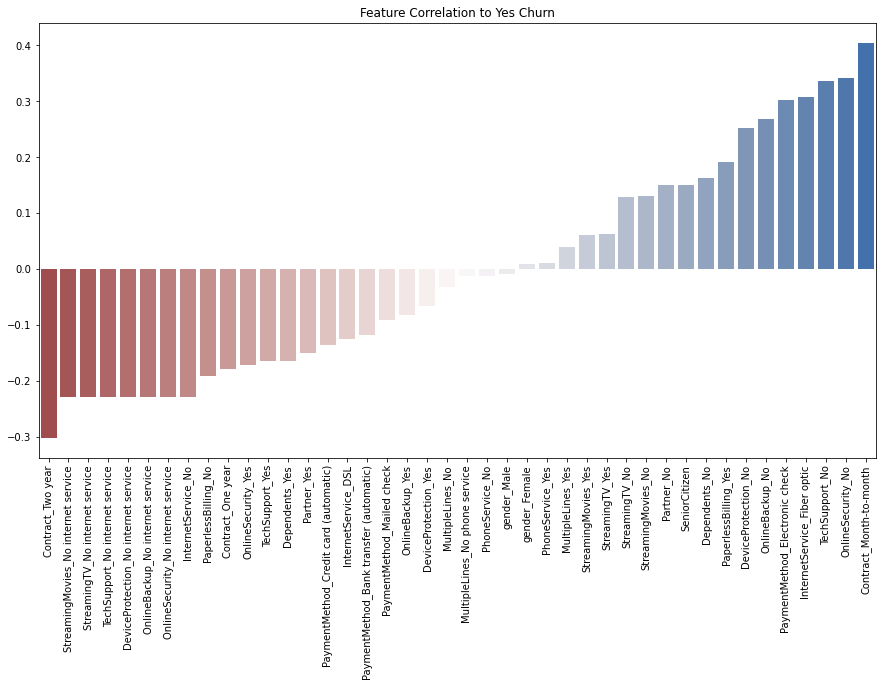

In [173]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(ax=ax, x=corr_sort.index, y=corr_sort.values, palette='vlag_r')
ax.set_title('Feature Correlation to Yes Churn')
ax.set_xticklabels(corr_sort.index, rotation=90);

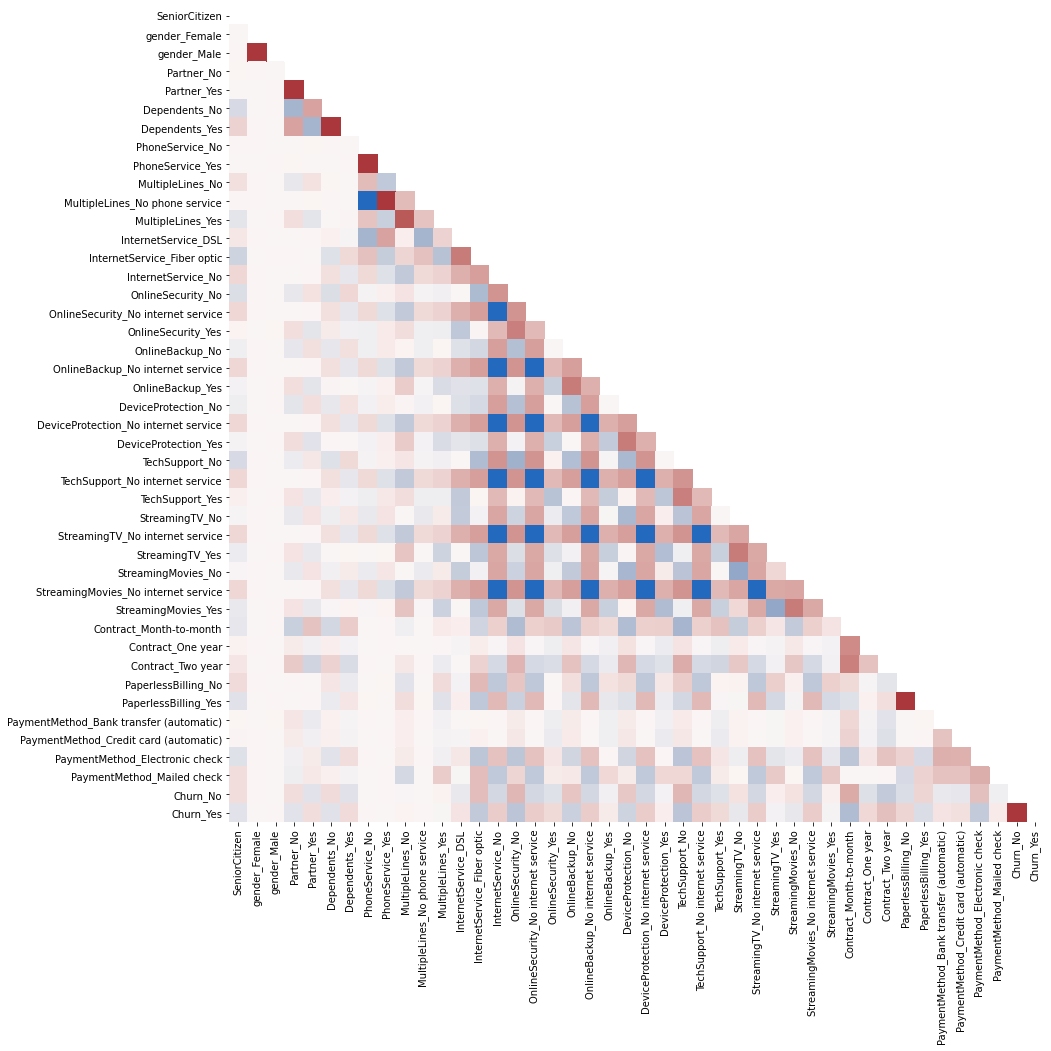

In [174]:
corr2 = pd.get_dummies(df_subset, drop_first=False).corr()
fig, ax = plt.subplots(figsize=(15,15))
mask = np.triu(np.ones_like(corr2, dtype=bool))
sns.heatmap(corr2, mask=mask, center=0, annot=False, fmt='.2f', square=True, cmap='vlag_r', cbar=False, ax=ax);

#  Part 2: Customer Churn Cohort Analysis

### Goals for Part 2:
- Take a deeper dive into the data
- Segement the customer base for cohort analysis
- Explore the relationship between monthly charges and total charges

### The biggest groups of customers are concentrated at the beginning and at the end of the histogram
- Month-to-month contract likely to blame for the short tenure
- Longer-term contracts likely why many customers stay on for 70+ months
- Distribution plot confirms this suspicion

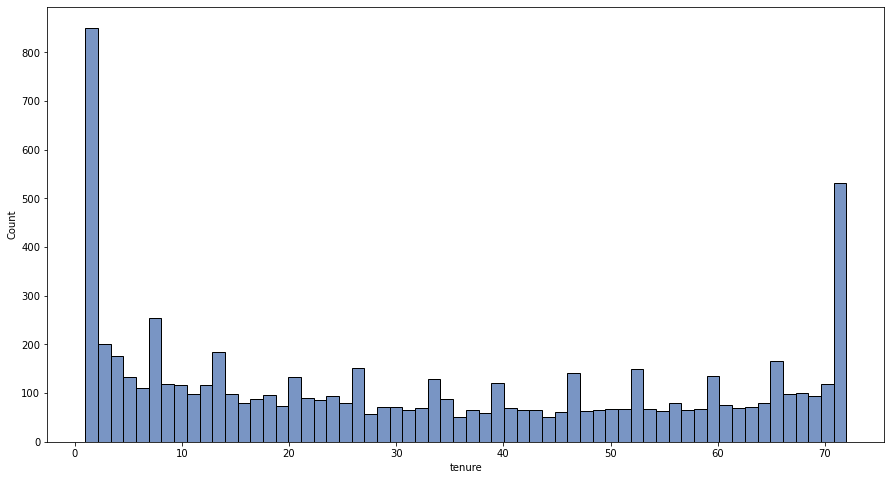

In [175]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=df, ax=ax, x='tenure', bins=60);

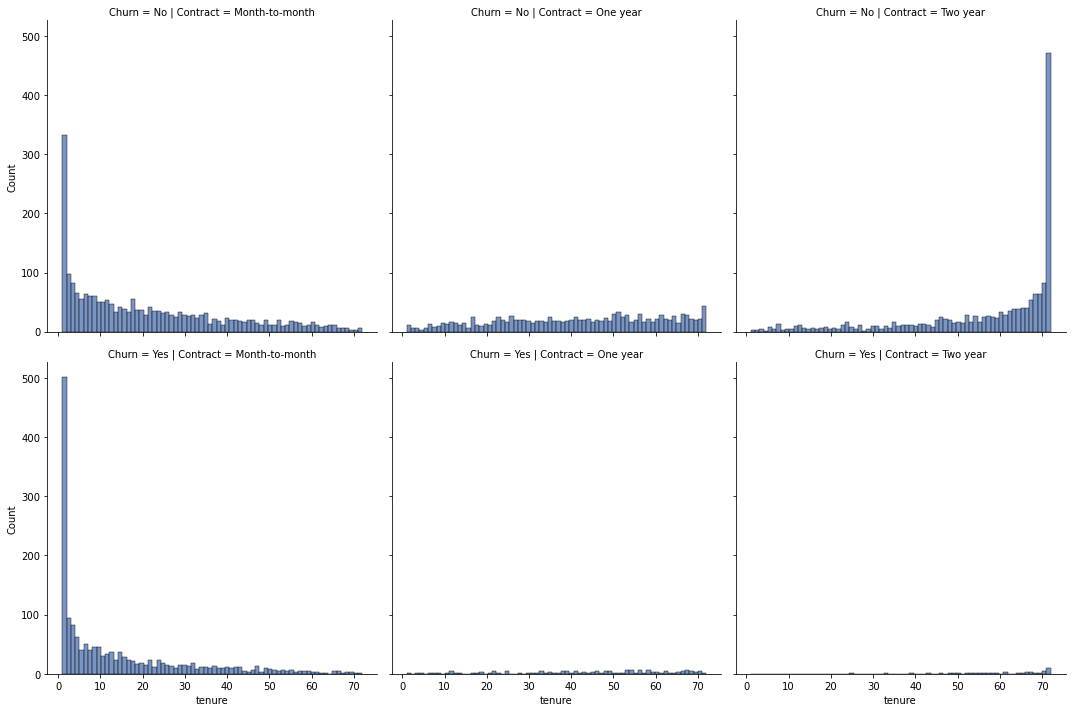

In [176]:
sns.displot(data=df, x='tenure', col='Contract', row='Churn', bins=70);

### Churn in Relation to charges
- The scatter plot seems to indicate that you are more likely to churn if you have a higher monthly charge

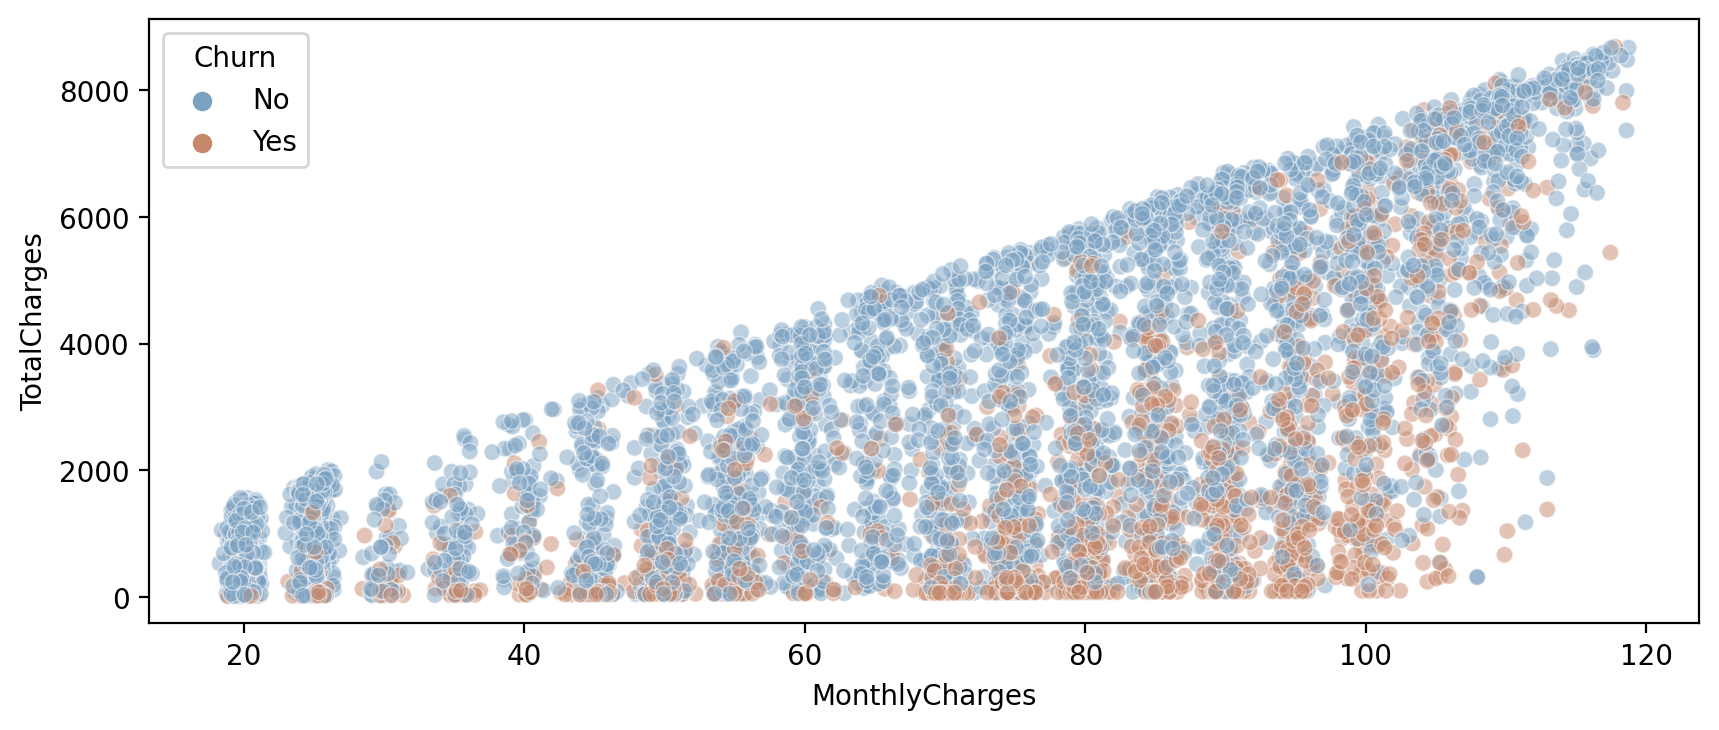

In [177]:
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
(sns.scatterplot(data=df, 
                 ax=ax, 
                 x='MonthlyCharges', 
                 y='TotalCharges',
                 hue='Churn', 
                 linewidth=0.5,
                 alpha=0.5, 
                 palette='twilight_shifted')
);

### Churn Rate
- We will convert the label into a numerical format
- This allows an easier calculation of churn rate
- By plotting the churn rate by each month, it is clear that the longer your tenure, the less likely you are to churn

In [178]:
churn_map = {'No': 0, 'Yes': 1}
churn_df = df.assign(Churn= df['Churn'].map(churn_map))

churn_df['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [179]:
churn_rate = churn_df.groupby('tenure').agg(churn_rate= ('Churn', 'mean')).mul(100)

churn_rate.head(10)

,churn_rate
tenure,
1,61.990212
2,51.680672
3,47.000000
4,47.159091
5,48.120301
6,36.363636
7,38.931298
8,34.146341
9,38.655462


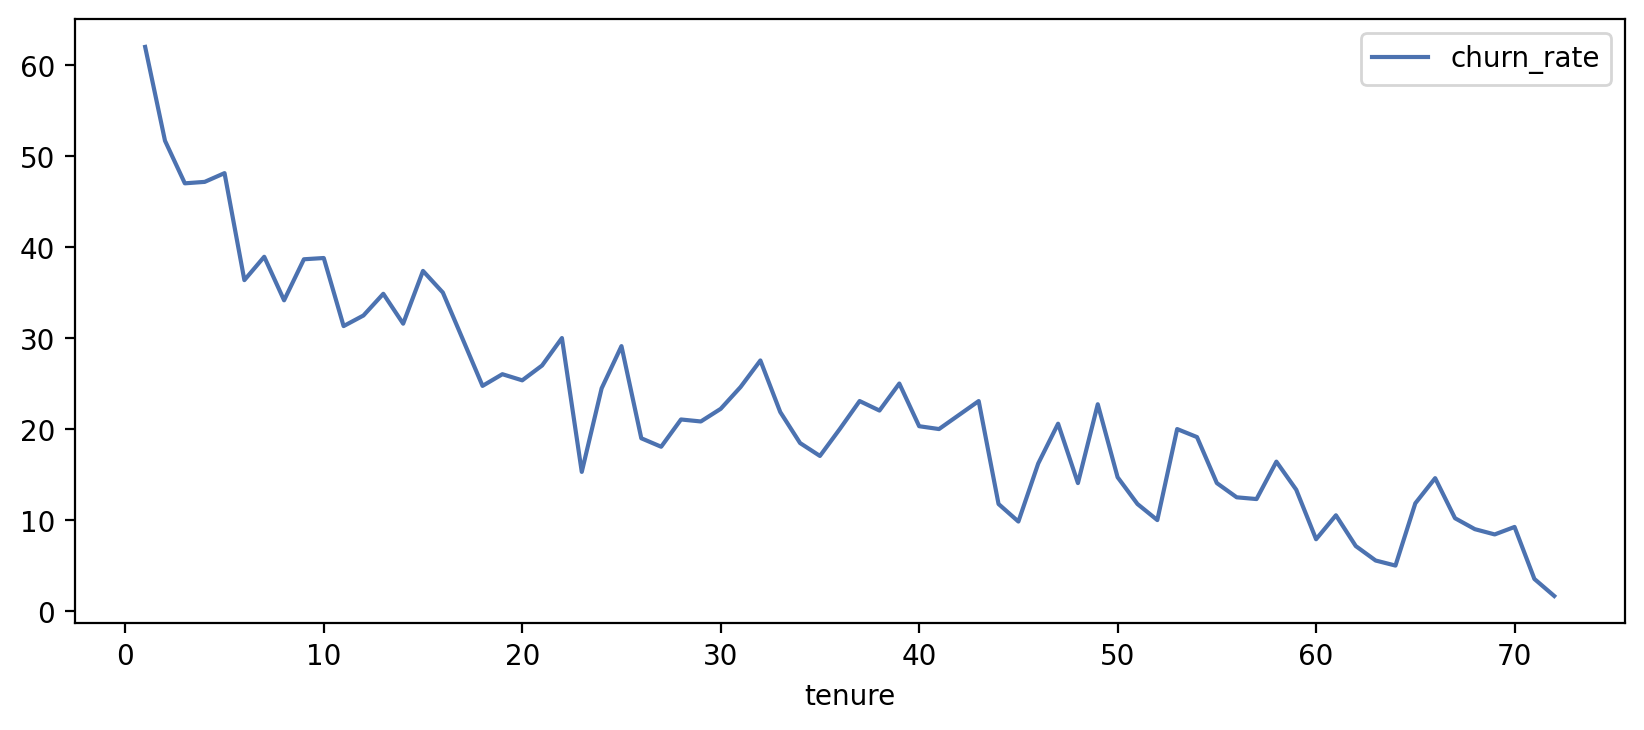

In [180]:
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
churn_rate.plot(ax=ax);

### Cohort Analysis
- We will convert the tenure feature into discrete categories
- We can then analyze each group easier
- The plots make it clear that customers who stay over 48 months are unlikley to churn
- It would also make business sense to try and lock customers into a 2 year contract

In [181]:
labels = ['0-12 Months', '12-24 Months', '24-48 Months', 'Over 48 Months']
bins = [-float("inf"), 12, 24, 48, float("inf")]

cohort_df = (df.assign(tenure_cohort= pd.cut(df['tenure'], bins=bins, labels=labels))
               .rename(columns={'tenure_cohort': 'Tenure Cohort'})
                    )

cohort_df[['tenure', 'Tenure Cohort']].head(20)

,tenure,Tenure Cohort
0,1,0-12 Months
1,34,24-48 Months
2,2,0-12 Months
3,45,24-48 Months
4,2,0-12 Months
5,8,0-12 Months
6,22,12-24 Months
7,10,0-12 Months
8,28,24-48 Months
9,62,Over 48 Months


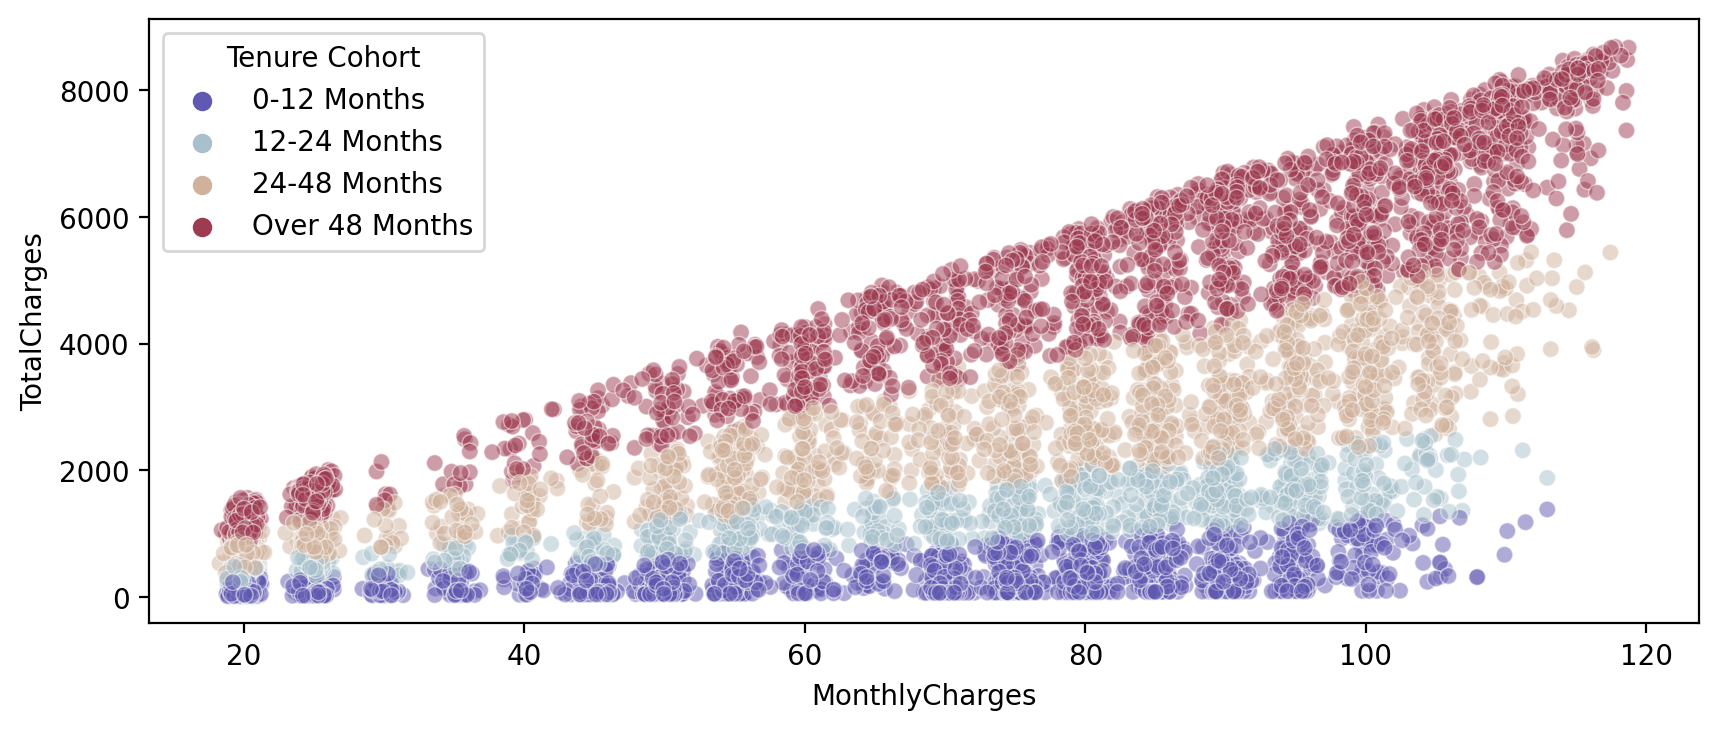

In [182]:
fig, ax = plt.subplots(figsize=(10,4), dpi=200)
(sns.scatterplot(ax=ax, 
                 data=cohort_df,
                 x='MonthlyCharges',
                 y='TotalCharges', 
                 hue='Tenure Cohort', 
                 linewidth=0.5,
                 alpha=0.5,
                 palette='twilight_shifted')
);

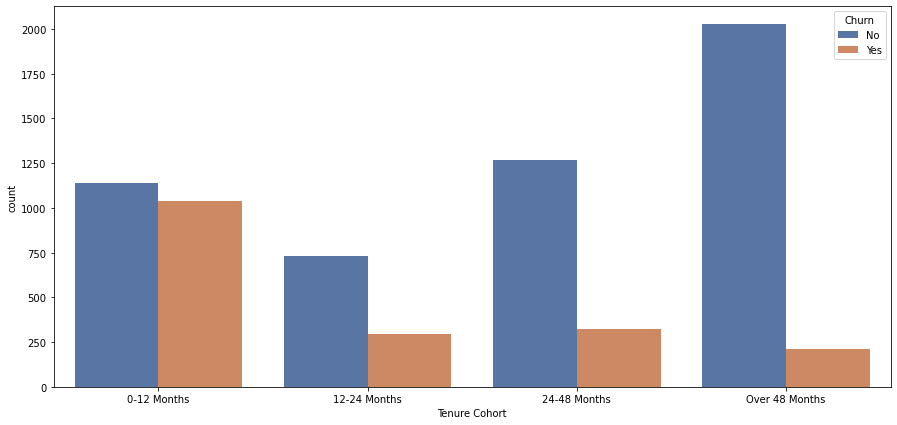

In [183]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(ax=ax, data=cohort_df, x='Tenure Cohort', hue='Churn');

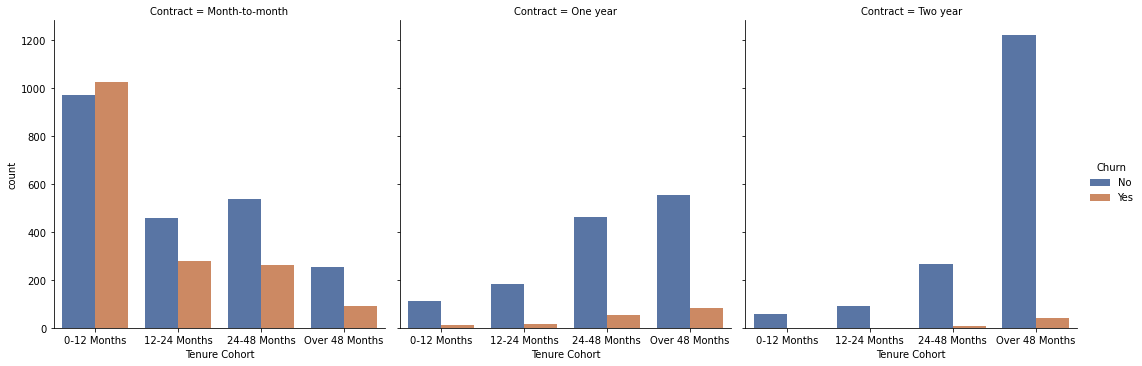

In [184]:
sns.catplot(data=cohort_df, x='Tenure Cohort', hue='Churn', col='Contract', kind='count');

# Part 3: Predictive Modeling

### Goals for Part 3:
- Build a predictive model to solve for our classification problem (will a customer churn?)
- Premium is placed on correctly predicting the customers who will churn, so we can potentially intervene and keep them around!
    - We will apply the following Tree Models:
        - Decision Tree
        - Random Forest
        - AdaBoost
        - Gradient Boost
- Why tree models?
    - Efficent for classification problems 
    - Versatile, easy to intepret
    - Data doesn't have to be scaled / normalized prior to modeling
- Find the optimal hyperparameters through a grid search
- Score our models to test for accuracy, recall, precision and F-1 score
- Plot a confusion matrix to visualize performance for each model
    - Correct predictions
    - False positives
    - False negatives
 
### To balance out the data set you can do one of the following:
- `from sklearn.utils import resample`

**Upsample minority class**
- Separate observations from each class into different DataFrames
- Resample *with replacement*, setting the number of samples to match that of the majority class
- Combine the up-sampled minority class DataFrame with the original majority class DataFrame

**Downsample majority class**
- Separate observations from each class into different DataFrames
- Resample *without replacement*, setting the number of samples to match that of the minority class
- Combine the down-sampled majority class DataFrame with the original minority class DataFrame

### We will upsample the minority class for this project
- Dataset isn't very large, deleting the majority class might cause the model to not generalize well
- The resample will only be performed on the training split of the dataset

In [185]:
# test train split

X = df.drop(columns=['Churn','customerID'])
X = pd.get_dummies(X,drop_first=True)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [186]:
# analyze the classes

y_train_min = y_train[y_train.values=='Yes']
y_train_maj = y_train[y_train.values=='No']

X_train_min = X_train.loc[X_train.index.isin(y_train_min.index)]
X_train_maj = X_train.loc[~X_train.index.isin(y_train_min.index)]

print(f'Yes rows: {len(min_ix)}')
print(f'No rows: {len(maj_ix)}')
print(f'Total rows: {len(maj_ix) + len(min_ix)}')

Yes rows: 1722
No rows: 4606
Total rows: 6328


In [187]:
# resample minority class

X_train_resample = resample(X_train_min, 
                            replace=True,     # sample with replacement
                            n_samples=4606,    # to match majority class
                            random_state=101) # reproducible results

y_train_resample = resample(y_train_min, 
                            replace=True,     # sample with replacement
                            n_samples=4606,    # to match majority class
                            random_state=101) # reproducible results

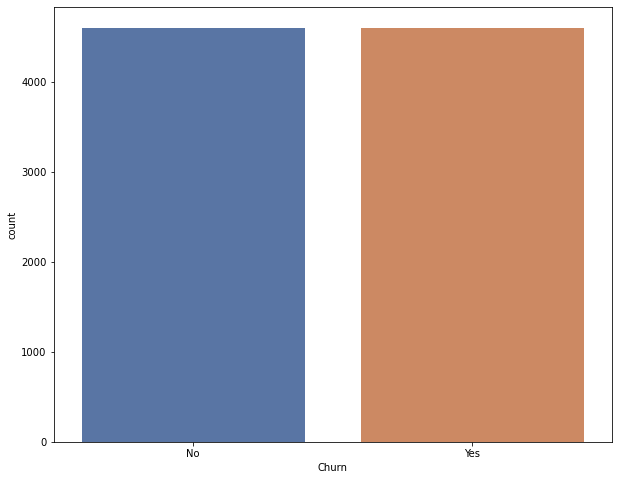

In [188]:
# combine the majority and minority test samples
X_train_r = pd.concat([X_train_maj, X_train_resample])
y_train_r = pd.concat([y_train_maj, y_train_resample])

# combine X and y to test for balanced classes
train_df = pd.concat([X_train_r, y_train_r], axis='columns')

fig, ax = plt.subplots(figsize=(10,8))

# classes are balanced
sns.countplot(data=train_df, x='Churn', ax=ax);

In [189]:
# params to use for GridSearchCV
param_grid = {
    'max_depth' : [n for n in range(1,10)],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1,2]
}

# decision tree
dt = DecisionTreeClassifier()
dt_r = DecisionTreeClassifier()

# gridsearch
clf = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)
clf_r = GridSearchCV(estimator=dt_r, param_grid=param_grid, cv=5)

clf.fit(X_train, y_train)
clf_r.fit(X_train_r, y_train_r)

print(clf.best_params_)
print(clf_r.best_params_)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [190]:
print(clf.best_estimator_)
print(clf_r.best_estimator_)

DecisionTreeClassifier(max_depth=5)
DecisionTreeClassifier(max_depth=9)


In [191]:
y_pred = clf.predict(X_test)
y_pred_r = clf_r.predict(X_test)

### Original Dataset vs. Resampled Dataset
- Our "mistakes" in the confusion matrix are:
    - Bottom left quadrant (false negatives)
    - Top right quadrant (false positives)
- Less false negatives in the resampled dataset model
- **this is a good thing!**
    - More important to catch the potential churners and attempt to keep them, even if they weren't going to churn
    - Recall of the "Yes" class is what we are after
        - The resampled dataset scores much higher in this area

In [192]:
print('Decision Tree Original Data:')
print(classification_report(y_test,y_pred))
print('Decision Tree Resampled Data:')
print(classification_report(y_test,y_pred_r))

Decision Tree Original Data:
              precision    recall  f1-score   support

          No       0.86      0.89      0.88       557
         Yes       0.52      0.44      0.47       147

    accuracy                           0.80       704
   macro avg       0.69      0.66      0.67       704
weighted avg       0.79      0.80      0.79       704

Decision Tree Resampled Data:
              precision    recall  f1-score   support

          No       0.92      0.71      0.80       557
         Yes       0.41      0.78      0.54       147

    accuracy                           0.72       704
   macro avg       0.67      0.74      0.67       704
weighted avg       0.82      0.72      0.75       704



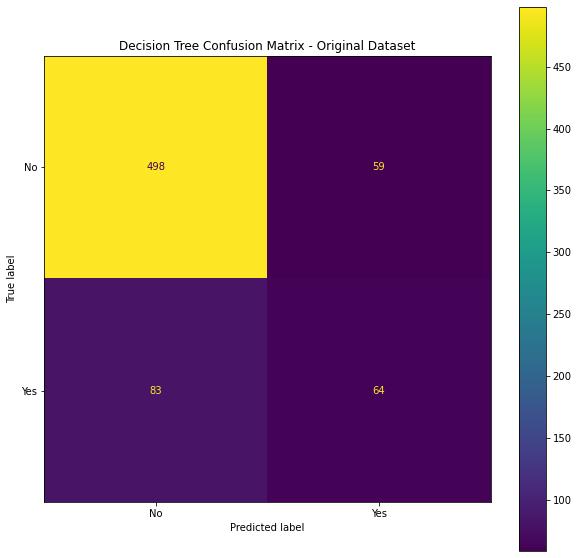

In [193]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Decision Tree Confusion Matrix - Original Dataset')
plot_confusion_matrix(clf,X_test,y_test, ax=ax);

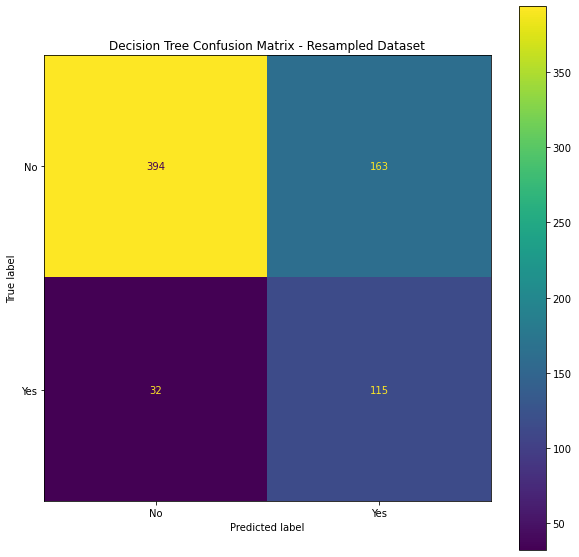

In [194]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Decision Tree Confusion Matrix - Resampled Dataset')
plot_confusion_matrix(clf_r,X_test,y_test, ax=ax);

In [195]:
imp_feats = pd.DataFrame(data=clf.best_estimator_.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance", ascending=False)
imp_feats

,Feature Importance
tenure,0.452239
InternetService_Fiber optic,0.340223
TotalCharges,0.044603
PaymentMethod_Electronic check,0.031130
OnlineBackup_No internet service,0.028480
MonthlyCharges,0.024671
Contract_Two year,0.023321
SeniorCitizen,0.010185
Contract_One year,0.009622
TechSupport_Yes,0.008523


In [196]:
imp_feats_r = pd.DataFrame(data=clf_r.best_estimator_.feature_importances_,index=X.columns,columns=['Feature Importance']).sort_values("Feature Importance", ascending=False)
imp_feats_r

,Feature Importance
Contract_Two year,0.295408
Contract_One year,0.183149
tenure,0.113481
MonthlyCharges,0.107865
TotalCharges,0.093261
InternetService_Fiber optic,0.073889
PaymentMethod_Electronic check,0.018680
StreamingMovies_Yes,0.011748
PaperlessBilling_Yes,0.011433
OnlineSecurity_Yes,0.010944


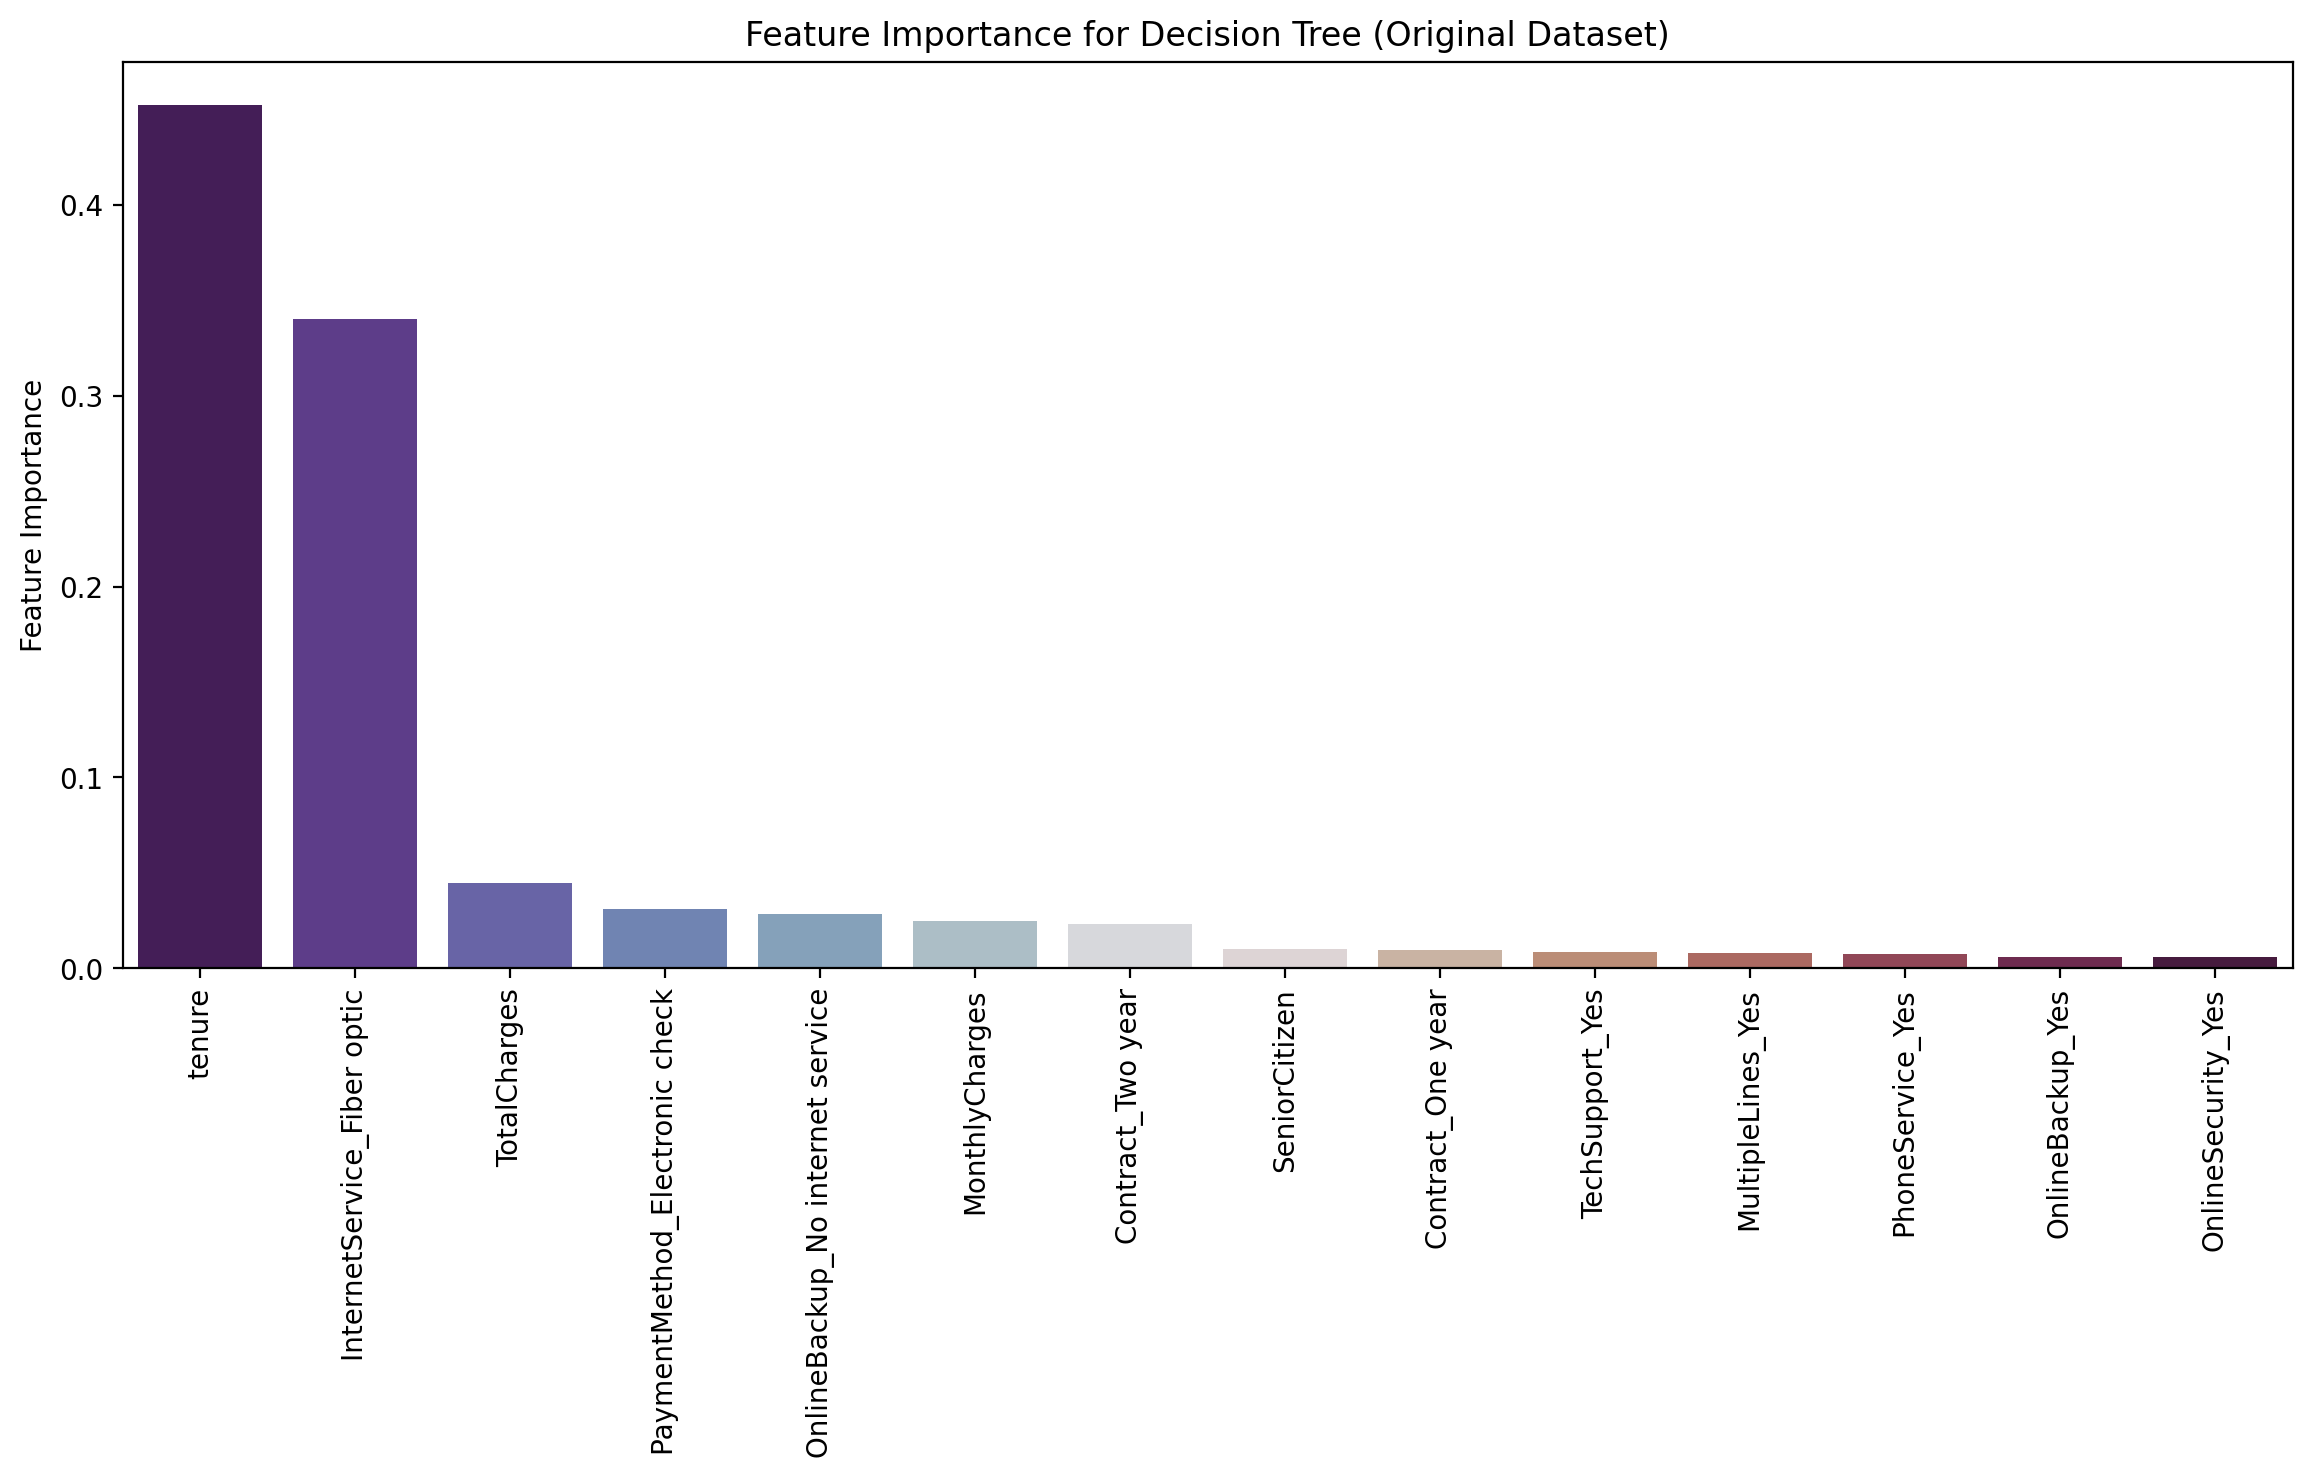

In [197]:
imp_feats = imp_feats[imp_feats['Feature Importance']> 0]
fig, ax = plt.subplots(figsize=(14,6),dpi=200)
sns.barplot(ax=ax, x=imp_feats.index, y=imp_feats['Feature Importance'], palette='twilight_shifted')
ax.set_title('Feature Importance for Decision Tree (Original Dataset)')
ax.set_xticklabels(imp_feats.index, rotation=90);

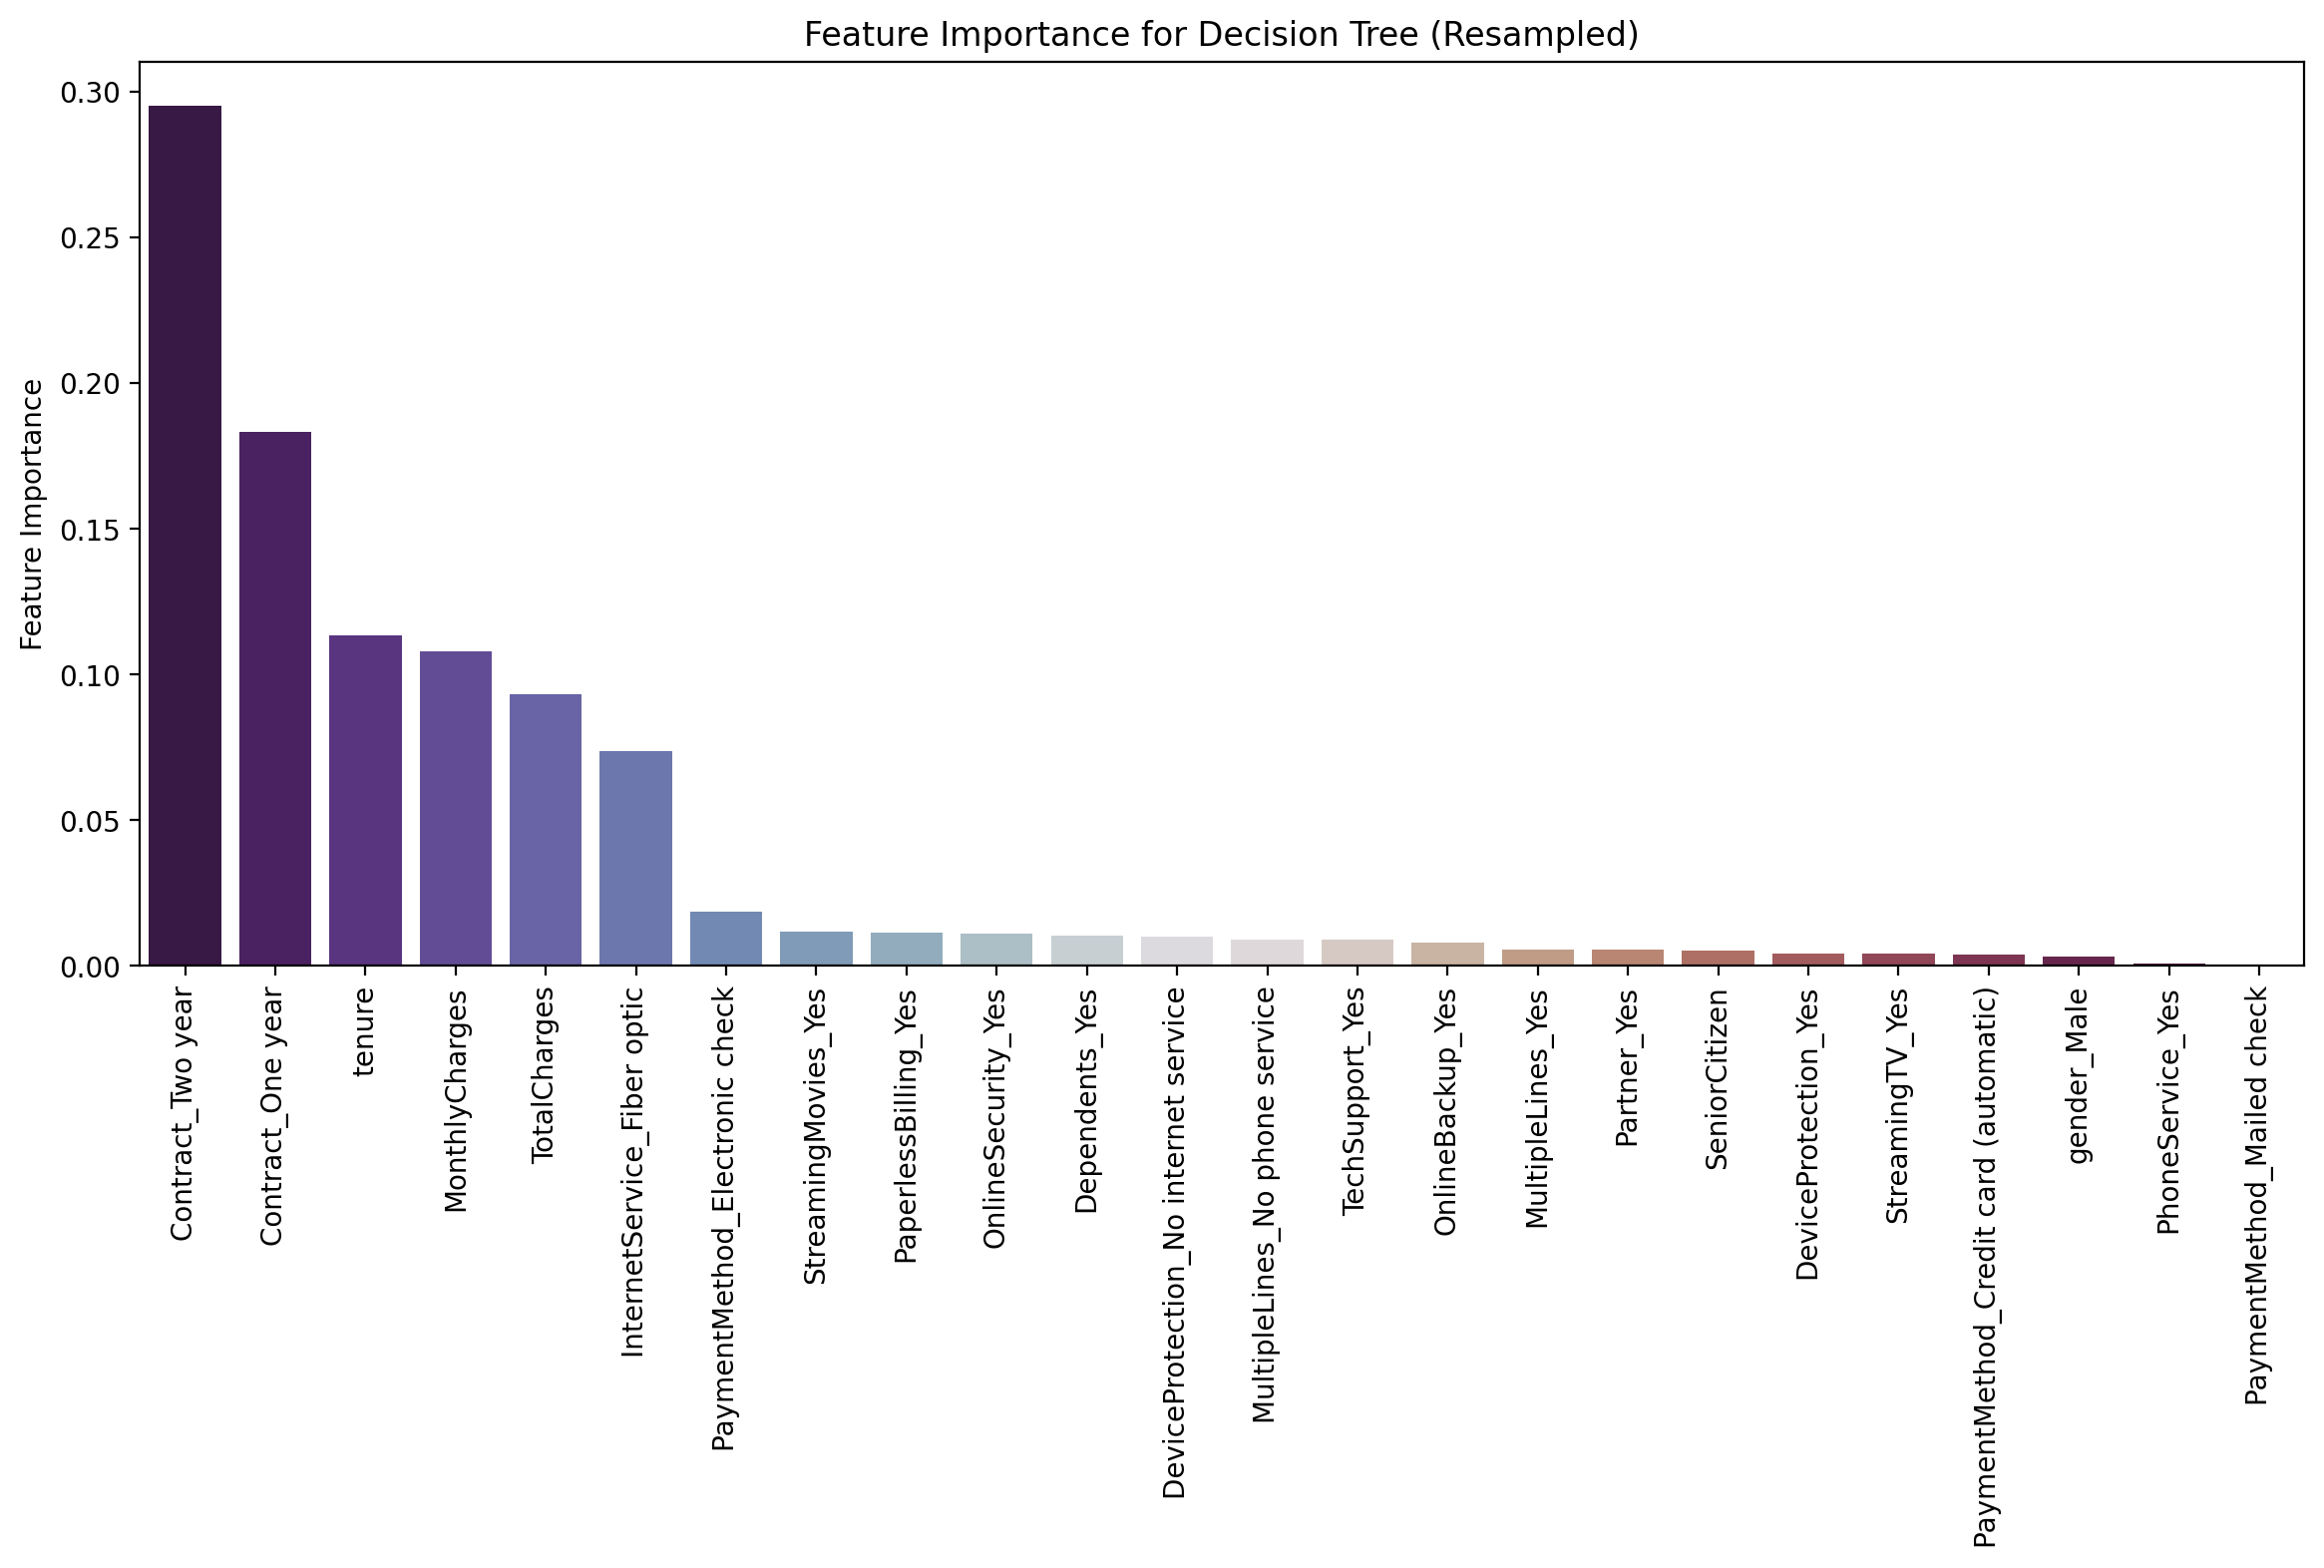

In [198]:
imp_feats_r = imp_feats_r[imp_feats_r['Feature Importance']> 0]
fig, ax = plt.subplots(figsize=(14,6),dpi=200)
sns.barplot(ax=ax, x=imp_feats_r.index, y=imp_feats_r['Feature Importance'], palette='twilight_shifted')
ax.set_title('Feature Importance for Decision Tree (Resampled)')
ax.set_xticklabels(imp_feats_r.index, rotation=90);

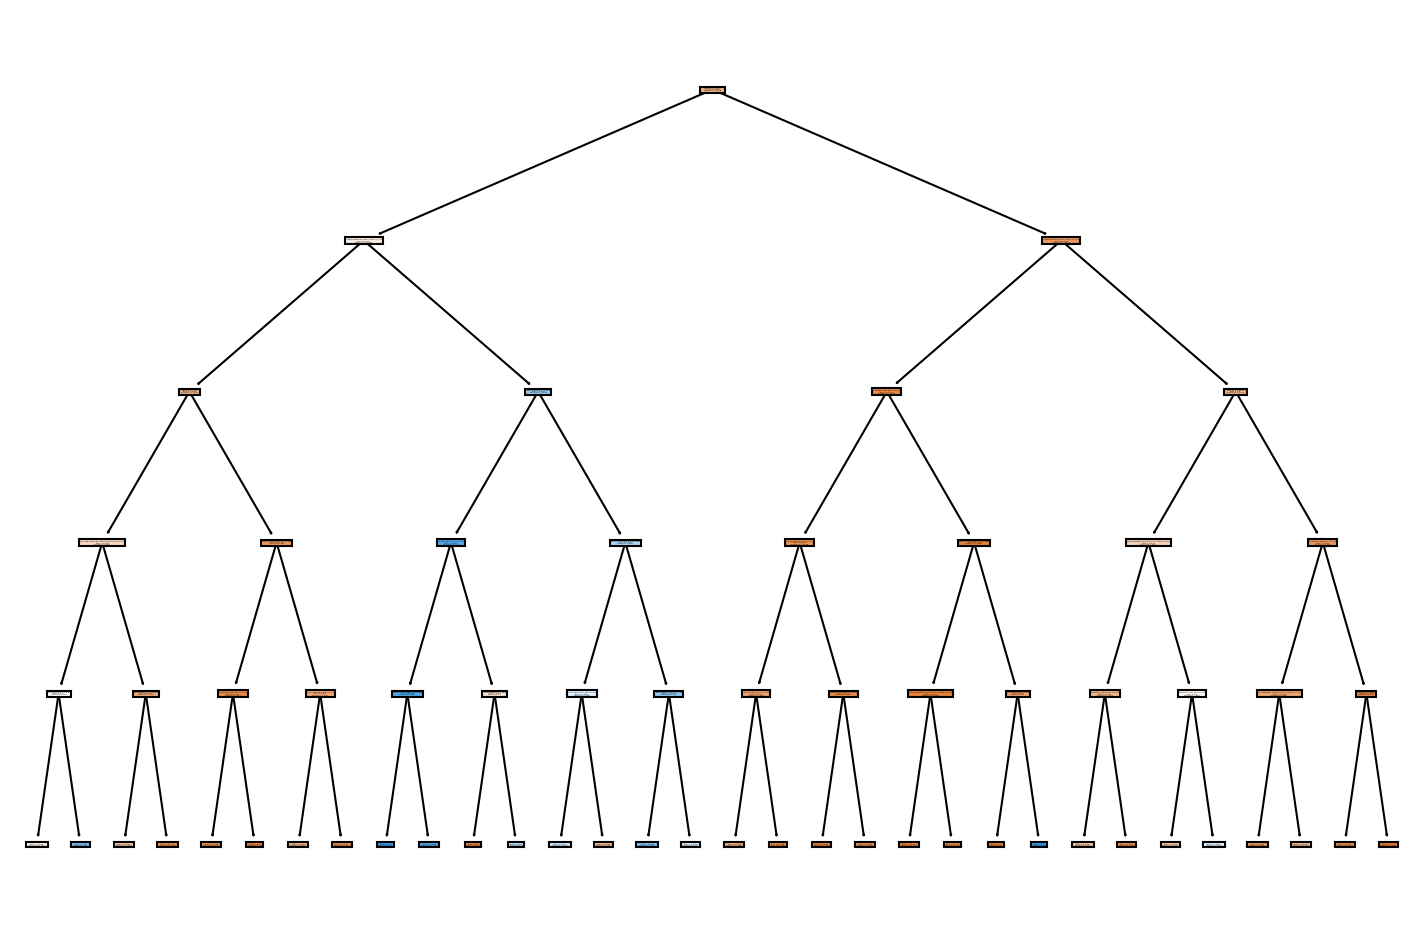

In [199]:
fig, ax = plt.subplots(figsize=(12,8),dpi=150)
plot_tree(clf.best_estimator_,filled=True,feature_names=X.columns);

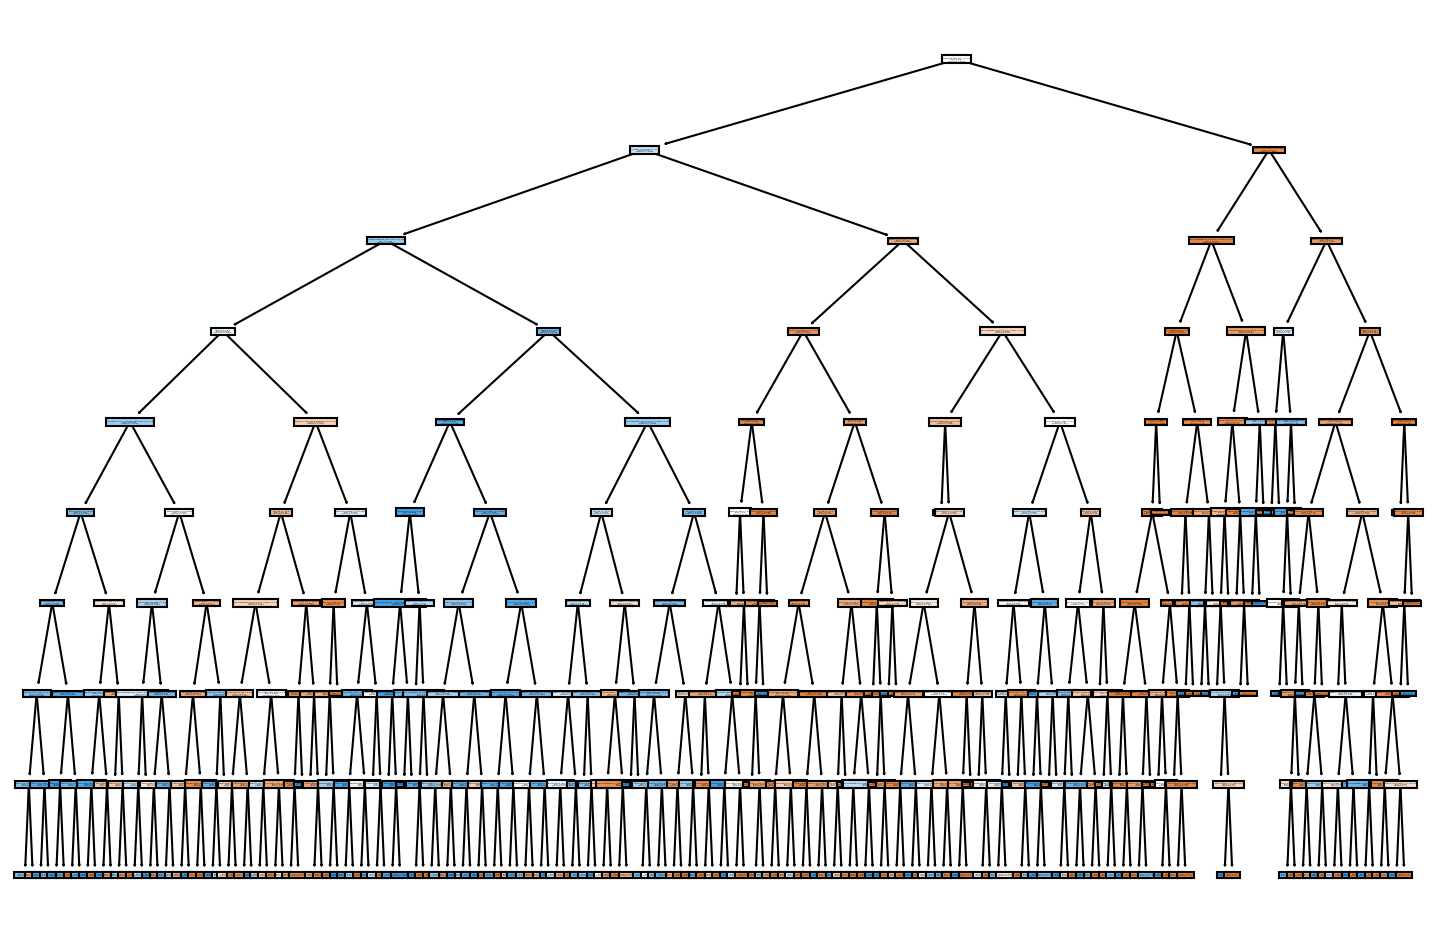

In [200]:
fig, ax = plt.subplots(figsize=(12,8),dpi=150)
plot_tree(clf_r.best_estimator_,filled=True,feature_names=X.columns);

In [201]:
rf = RandomForestClassifier()
rf_r = RandomForestClassifier()

clf_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
clf_rf_r = GridSearchCV(estimator=rf_r, param_grid=param_grid, cv=5)

clf_rf.fit(X_train, y_train)
clf_rf_r.fit(X_train_r, y_train_r)

print(clf_rf.best_estimator_)
print(clf_rf_r.best_estimator_)

RandomForestClassifier(max_depth=8, min_samples_split=4)
RandomForestClassifier(max_depth=9)


In [202]:
y_pred = clf_rf.predict(X_test)
y_pred_r = clf_rf_r.predict(X_test)

print('RandomForest Original Data:')
print(classification_report(y_test,y_pred))
print('RandomForest Resampled Data:')
print(classification_report(y_test,y_pred_r))

RandomForest Original Data:
              precision    recall  f1-score   support

          No       0.87      0.91      0.89       557
         Yes       0.60      0.48      0.53       147

    accuracy                           0.82       704
   macro avg       0.73      0.70      0.71       704
weighted avg       0.81      0.82      0.82       704

RandomForest Resampled Data:
              precision    recall  f1-score   support

          No       0.91      0.75      0.83       557
         Yes       0.44      0.73      0.55       147

    accuracy                           0.75       704
   macro avg       0.68      0.74      0.69       704
weighted avg       0.82      0.75      0.77       704



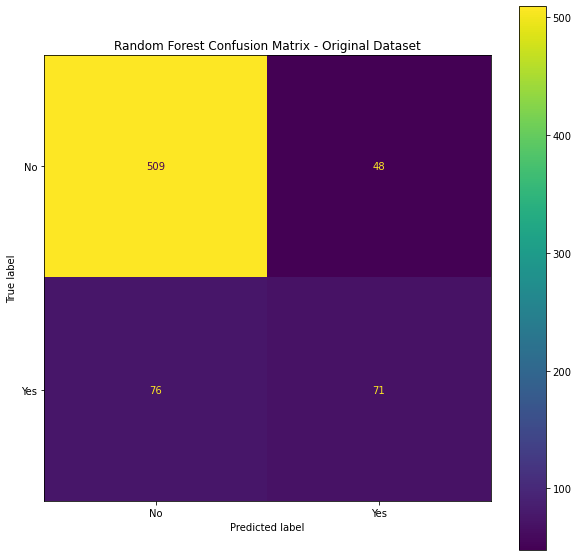

In [203]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Random Forest Confusion Matrix - Original Dataset')
plot_confusion_matrix(clf_rf,X_test,y_test, ax=ax);

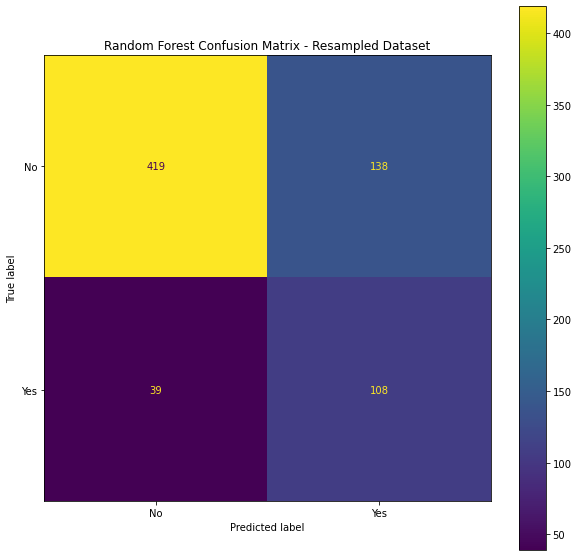

In [204]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Random Forest Confusion Matrix - Resampled Dataset')
plot_confusion_matrix(clf_rf_r,X_test,y_test, ax=ax);

### Boosted Models
- AdaBoost
- Gradient Boost

In [205]:
ada_model = AdaBoostClassifier()
ada_model_r = AdaBoostClassifier()

gb_model = GradientBoostingClassifier()
gb_model_r = GradientBoostingClassifier()

param_grid = {
    'n_estimators' : [25, 50, 75, 100]
}

clf_ada = GridSearchCV(estimator=ada_model, param_grid=param_grid, cv=5)
clf_ada_r = GridSearchCV(estimator=ada_model_r, param_grid=param_grid, cv=5)

clf_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5)
clf_gb_r = GridSearchCV(estimator=gb_model_r, param_grid=param_grid, cv=5)

clf_ada.fit(X_train, y_train)
clf_ada_r.fit(X_train_r, y_train_r)

clf_gb.fit(X_train, y_train)
clf_gb_r.fit(X_train_r, y_train_r)

print(clf_ada.best_estimator_)
print(clf_ada_r.best_estimator_)
print('')
print(clf_gb.best_estimator_)
print(clf_gb_r.best_estimator_)

AdaBoostClassifier(n_estimators=25)
AdaBoostClassifier(n_estimators=100)

GradientBoostingClassifier(n_estimators=75)
GradientBoostingClassifier()


In [206]:
y_pred = clf_ada.predict(X_test)
y_pred_r = clf_ada_r.predict(X_test)

y_pred_gb = clf_gb.predict(X_test)
y_pred_gb_r = clf_gb_r.predict(X_test)

print('AdaBoost Original Data:')
print(classification_report(y_test,y_pred))
print('AdaBoost Resampled Data:')
print(classification_report(y_test,y_pred_r))
print('')
print('GradientBoost Original Data:')
print(classification_report(y_test,y_pred_gb))
print('GradientBoost Resampled Data:')
print(classification_report(y_test,y_pred_gb_r))

AdaBoost Original Data:
              precision    recall  f1-score   support

          No       0.88      0.91      0.89       557
         Yes       0.60      0.52      0.55       147

    accuracy                           0.83       704
   macro avg       0.74      0.71      0.72       704
weighted avg       0.82      0.83      0.82       704

AdaBoost Resampled Data:
              precision    recall  f1-score   support

          No       0.93      0.74      0.82       557
         Yes       0.44      0.79      0.57       147

    accuracy                           0.75       704
   macro avg       0.69      0.76      0.69       704
weighted avg       0.83      0.75      0.77       704


GradientBoost Original Data:
              precision    recall  f1-score   support

          No       0.88      0.91      0.89       557
         Yes       0.60      0.51      0.55       147

    accuracy                           0.83       704
   macro avg       0.74      0.71      0.72      

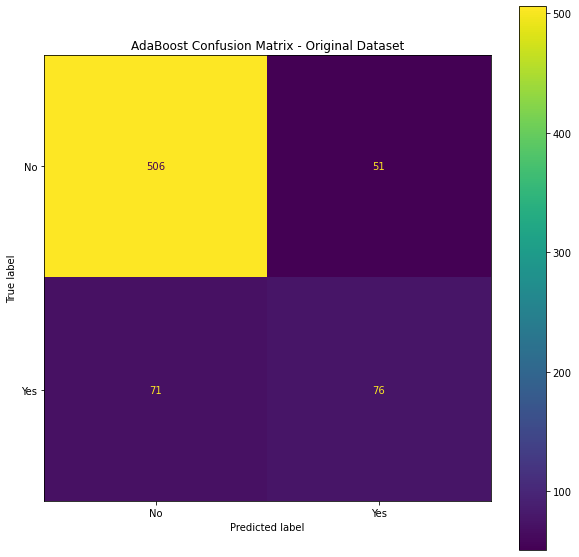

In [207]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('AdaBoost Confusion Matrix - Original Dataset')
plot_confusion_matrix(clf_ada,X_test,y_test, ax=ax);

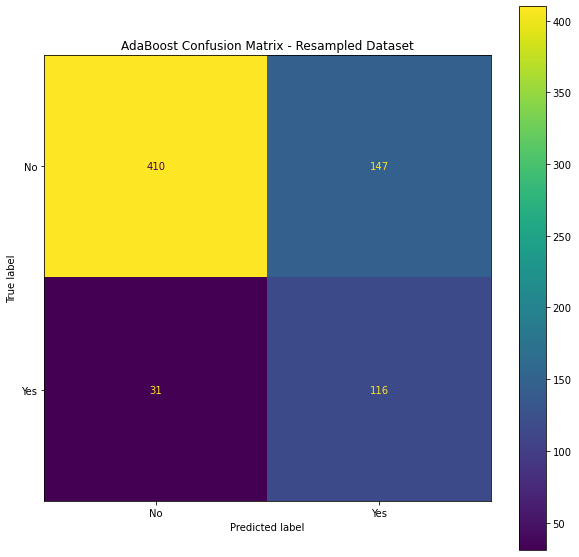

In [208]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('AdaBoost Confusion Matrix - Resampled Dataset')
plot_confusion_matrix(clf_ada_r,X_test,y_test, ax=ax);

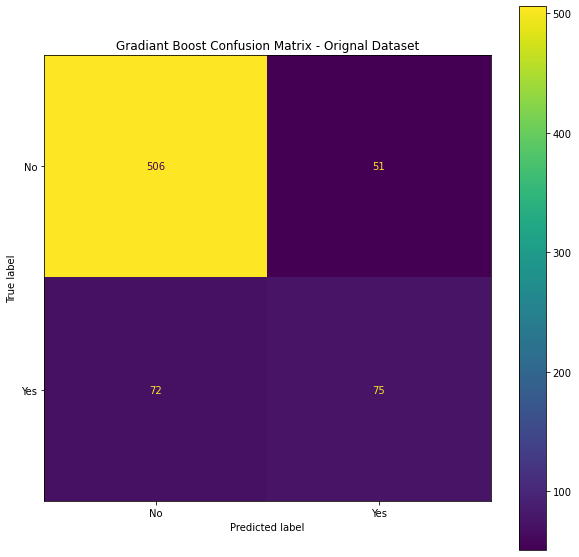

In [209]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Gradiant Boost Confusion Matrix - Orignal Dataset')
plot_confusion_matrix(clf_gb,X_test,y_test, ax=ax);

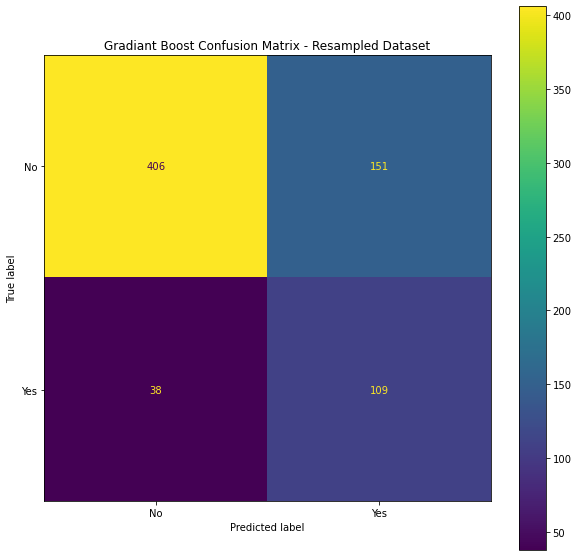

In [210]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Gradiant Boost Confusion Matrix - Resampled Dataset')
plot_confusion_matrix(clf_gb_r,X_test,y_test, ax=ax);

### Takeaways:
- AdaBoost using resampled data had the lowest amount of false negatives
    - DecisionTree just barely came in second
 - DecisionTree had the best recall score for the "Yes" class